# ブロックのtotal gasLimitとtotal gasUsedの一覧を取得してグラフ表示する
blockのgasLimitとtransactionに設定されたgasLimitの合計とgasUsedを比較するグラフを生成する

### 必要なライブラリをインポート
GraphQLを使ってローカルに立てたノードからブロック情報を一括取得して解析するのひ必要なライブライをimportする。

In [99]:
import json
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

取得するブロックの範囲を定義

In [100]:
# tip block [2022/08/27 03:06] 15,416,816
start = 15416600
end =   15416700
step = 1000

In [101]:
query = """query GetBlocks($start: Long!, $end: Long!) {
      blocks(from: $start, to: $end) {
        number,
        gasLimit,
        gasUsed,
        transactions {
          gas,
          gasUsed,
        }
      }
    }"""

# baseFeesをgwei単位に変換するために定義
gwei_unit = 1000000000


## go-ethereumからデータを取得

In [102]:
client = Client(
    transport=RequestsHTTPTransport(
      url = "http://192.168.10.10:8545/graphql",
      use_json = True,
      headers = {
        "Content-type": "application/json",
        "Content-Length": str(len(query))
      },
      retries = 3,
    ),
    fetch_schema_from_transport=True,
)

blocks = []
for bfrom in np.arange(start, end, step):
    bto = bfrom+step
    print(f"start={bfrom}, end={bto}")
    
    if bto > end:
        bto = end
    variable = {"start": str(bfrom+1), "end": str(bto)}
    resp = client.execute(
      gql(query),
      variable_values = variable)
    blocks.extend(resp["blocks"])
    print(f"{variable} load end. blocks.len={len(blocks)}")

print(len(blocks))
print("load OK")

# print(json.dumps(blocks[0], indent=2))

start=15416600, end=15417600
{'start': '15416601', 'end': '15416700'} load end. blocks.len=100
100
load OK


## 取得したデータをグラフにプロット

     limits     useds  totalLimitsOfTx
0  29970676  26238850         46819082
1  29999943   6947662         13452460
2  29970648  29965927         63306736
3  29999915  21948062         40152590
4  30000000   8404148         24784390
100


/tmp/ipykernel_26437/343701887.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


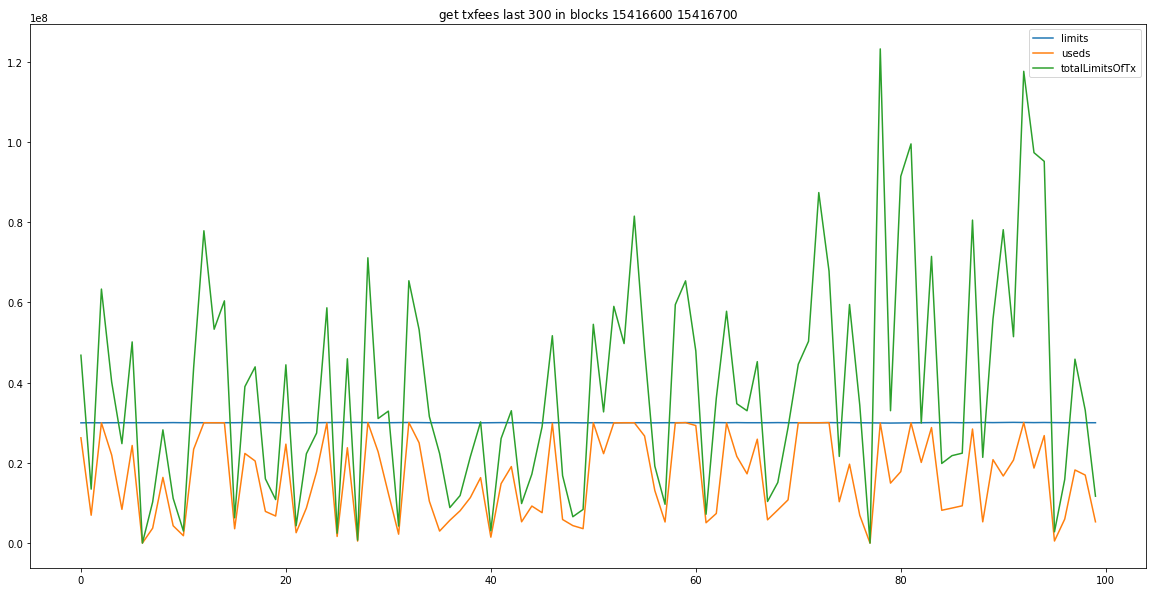

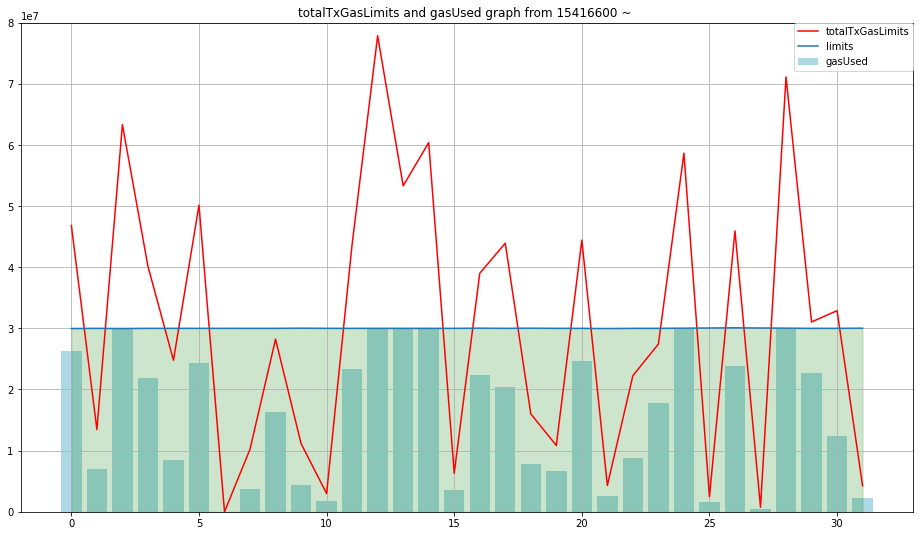

In [105]:
def totalGasLimitFromTx(transactions):
    totalGasLimit = 0
    for tx in transactions:
        totalGasLimit += int(tx['gas'], 16)

    return totalGasLimit

totalGasLimits = list()
limits = list()
useds = list()
for block in blocks:
    gasLimit = block['gasLimit']
    gasUsed = block['gasUsed']
    totalGasLimitOfTx = totalGasLimitFromTx(block['transactions'])
    
    limits.append(gasLimit)
    useds.append(gasUsed)
    totalGasLimits.append(totalGasLimitOfTx)
   
df = pd.DataFrame({
    "limits": limits,
    "useds": useds,
    "totalLimitsOfTx": totalGasLimits
})

print(df[:5])
print(len(df))
df.plot(title=f"get txfees last 300 in blocks ${start} ~ ${end}", figsize=(20,10))

# 対象ブロック数を削減
graph_limit = 32
df = df[:graph_limit]
numbers = range(0, graph_limit)


fig, ax1 = plt.subplots(1,1,figsize=(16,9))
# ax2 = ax1.twinx()
ax1.bar(numbers, df["useds"],color="lightblue",label="gasUsed")
ax1.plot(numbers, df["totalLimitsOfTx"], color="red", label="totalTxGasLimits")
ax1.plot(numbers, df["limits"], label='limits')    # y1+y2 のグラフ
ax1.fill_between(numbers, df["limits"], 0 ,df["limits"], color='g', alpha=0.2)  # グラフ間を塗りつぶす
ax1.set_ylim(0,80000000)
handler1, label1 = ax1.get_legend_handles_labels()
ax1.legend(handler1,label1,borderaxespad=0)
ax1.grid(True)
plt.title(f"totalTxGasLimits and gasUsed graph from {start} ~ ")
fig.savefig("gasLimitUsed.png")